# FTE/BTE Experiment for DTD

The progressive learning package utilizes representation ensembling algorithms to sequentially learn a representation for each task and ensemble both old and new representations for all future decisions. 

Here, a representation ensembling algorithm based on decision forests (SynF) and an algorithm based on neural networks (SynN) demonstrate forward and backward knowledge transfer of tasks on the Describable Textures Dataset (DTD). The original dataset can be found at https://www.robots.ox.ac.uk/~vgg/data/dtd/.

### Import necessary packages and modules

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from multiprocessing import Pool
import seaborn as sns
from matplotlib import rcParams

rcParams.update({"figure.autolayout": True})

### Experimental Set-up

DTD has 47 classes of food with 120 images each. For the purposes of this experiment, only 40 of those classes are used. The dataset is split into 10 tasks with 4 classes each. 

Each class is then split into 4 batches of 30 images each. Every time the experiment is repeated, the batch used as the test set is shifted.

The remaining 90 images in each class are used for training each task.

With 4 batches of test sets and 1 batch of training sets, the number of permutations comes out to 4, so the final errors are averaged across 4 trials and then used to calculate FTE and BTE

### DTD Data Generation

DTD was downloaded and preprocessed (images were padded and resized) by running the algorithms found in https://github.com/neurodata/LLF_tidy_images. This sectipn of the notebook serves to take those processed images and convert them into numpy arrays that can be read and used by the progressive learning algorithms.

In [2]:
# Load data set
data_dir = "../../../datasets_resized_wLabels/dtd/images"  # replace with the path name for wherever the downloaded dtd images have been stored
textures_sorted = sorted(os.listdir(data_dir))

Start reading the image data into numpy arrays. Only the first 40 out of the 47 sorted texture classes will be used in order to make it easier to split up the samples into tasks later on.

This process of initializing each x data array with some images and then concatenating to get the next batch of 1200 images is repeated 4 times, resulting in 4 numpy arrays each containing all the images from 10 of the dtd classes.

In [3]:
dict_x = {}
for k in range(4):
    # Initialize data_x* with the first image in the first class, then concatenate to acquire all images from the first class
    texture_class = os.listdir(os.path.join(data_dir, textures_sorted[10 * k]))
    data_xk = [
        plt.imread(os.path.join(data_dir, textures_sorted[10 * k], texture_class[0]))
    ]

    for i in range(1, 120):
        data_xk = np.concatenate(
            [
                data_xk,
                [
                    (
                        plt.imread(
                            os.path.join(
                                data_dir, textures_sorted[10 * k], texture_class[i]
                            )
                        )
                    )
                ],
            ]
        )

    # Add to the initialized data_x* array until it contains all images from the 10 classes
    # Concatenating more than 1200 images per batch increases the run time by a lot
    for j in range(((k * 10) + 1), (10 * (k + 1))):
        texture_class = os.listdir(os.path.join(data_dir, textures_sorted[j]))
        for i in range(0, 120):
            data_xk = np.concatenate(
                [
                    data_xk,
                    [
                        (
                            plt.imread(
                                os.path.join(
                                    data_dir, textures_sorted[j], texture_class[i]
                                )
                            )
                        )
                    ],
                ]
            )

    dict_x["data_x" + str(k + 1)] = data_xk

In [4]:
# Combine individual numpy arrays for x data for each batch of 10 classes all into one big numpy array
data_x = np.concatenate([dict_x["data_x1"], dict_x["data_x2"], dict_x["data_x3"]])
data_x = np.concatenate([data_x, dict_x["data_x4"]])

In [5]:
# Create y data containing 40 class labels
data_y = np.full((120), 0, dtype=int)
for i in range(1, 40):
    data_y = np.concatenate([data_y, np.full((120), i, dtype=int)])

### Train the model and perform validation

`which_task`: The task number for which BTE should be calculated

#### run_parallel_exp: 
Wrapper method for the `run_bte_exp` function which declares and trains the model, and performs validation with respect to the test data to compute the error of the model at a particular iteration

In [6]:
# Choose algorithm (synf or synn)
model = "synn"

In [7]:
from functions.fte_bte_dtd_functions import run_fte_bte_exp

fte = []
bte = []
te = []
accuracies = []

for which_task in range(1, 11):

    def run_parallel_exp(shift):

        df_list = run_fte_bte_exp(data_x, data_y, which_task, model, shift=shift)

        return df_list

    shifts = np.arange(0, 4, 1)  # Number of test set batches
    acc = []

    for shift in shifts:
        acc.append(run_parallel_exp(shift))

    # Average forward transfer accuracies accross all permutations of testing and training batches for each task
    acc_x = []
    acc_y = []
    acc_z = []
    for z in range(which_task):
        for y in range(1):
            for x in range(4):
                if model == "synn":
                    acc_x.append(acc[x][y]["task_accuracy"][z])
                elif model == "synf":
                    acc_x.append(acc[0][x][y]["task_accuracy"][z])
            acc_y.append(np.mean(acc_x))
            acc_x = []
        acc_z.append(np.mean(acc_y))
        acc_y = []

    # Calculate and store FTE
    fte.append((1 - acc_z[0]) / (1 - acc_z[-1]))

    # Average backward transfer accuracies accross all permutations of testing and training batches for each task
    acc_x = []
    acc_y = []
    acc_z = []
    for z in range((which_task - 1), 10):
        for y in range(1):
            for x in range(4):
                if model == "synn":
                    acc_x.append(acc[x][y]["task_accuracy"][z])
                elif model == "synf":
                    acc_x.append(acc[0][x][y]["task_accuracy"][z])
            acc_y.append(np.mean(acc_x))
            acc_x = []
        acc_z.append(np.mean(acc_y))
        acc_y = []

    # Calculate and store accuracies, BTE, and TE
    accuracies.append(acc_z)
    calc_bte = (1 - acc_z[0]) / ([1 - a for a in acc_z])
    bte.append(calc_bte)
    te.append([fte[(which_task - 1)] * a for a in calc_bte])

### Calculating FTE, BTE, TE, and Accuracy

The forward transfer efficiency of $f$ for task $t$ given $n$ samples is 
$$FTE_n^t (f) := \mathbb{E} [R^t (f(D_n^{t}) )] / \mathbb{E} [R^t (f(D_n^{<t}))]$$

We say an algorithm achieves forward transfer for task $t$ if and only if $FTE_n^t(f) > 1$. Intuitively, this means that the progressive learner has used data associated with past tasks to improve performance on task $t$. 

The backward transfer efficiency of $f$ for task $t$ given $n$ samples is 
$$BTE_n^t (f) := \mathbb{E} [R^t (f(D_n^{<t}) )] / \mathbb{E} [R^t (f(D_n))]$$

We say an algorithm achieves backward transfer for task $t$ if and only if $BTE_n^t(f) > 1$. Intuitively, this means that the progressive learner has used data associated with new tasks to improve performance on previous tasks. 

The transfer efficiency of $f$ for task $t$ given $n$ samples is 
$$TE_n^t (f) := \mathbb{E} [R^t (f(D_n^{t}) )] / \mathbb{E} [R^t (f(D_n))]$$

We say an algorithm has transfer learned for task $t$ with data $D_n$ if and only if $TE_n^t(f) > 1$.

### Plotting FTE, BTE, TE, and Accuracy
Run cell to generate a figure containing 4 plots of the forward transfer efficiency, backward transfer efficiency, transfer efficiency, and accuracy of the SynF/SynN algorithms. 

<ipython-input-8-1118e15100d6>:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0][0].set_yticklabels(log_lbl);
<ipython-input-8-1118e15100d6>:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0][1].set_yticklabels(log_lbl);
<ipython-input-8-1118e15100d6>:111: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1][0].set_yticklabels(log_lbl);


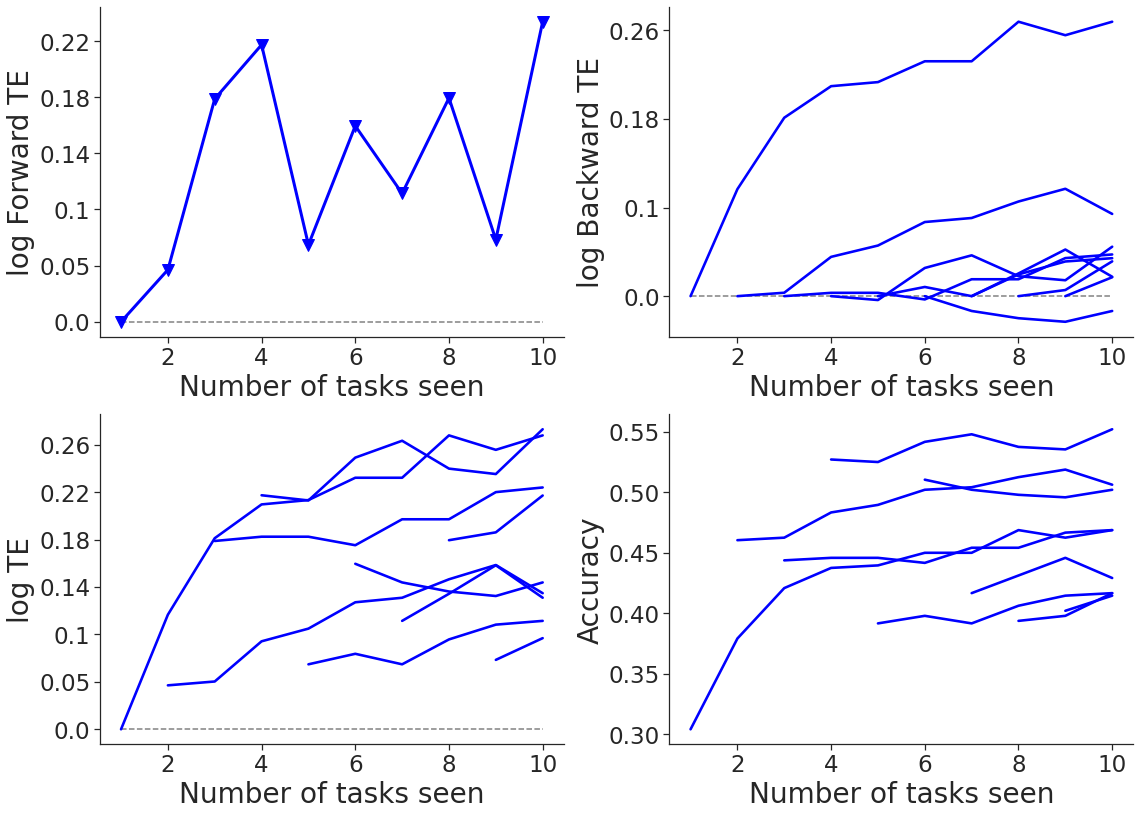

In [8]:
sns.set(style="ticks")
sns.despine

n_tasks = 10
# clr = ["#e41a1c", "#a65628", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#CCCC00"]
# c = sns.color_palette(clr, n_colors=len(clr))
if model == "synn":
    c = "blue"
elif model == "synf":
    c = "red"

fontsize = 28
ticksize = 23

# Plot FTE

fig, ax = plt.subplots(2, 2, figsize=(16, 11.5))
# fig.suptitle('ntrees = '+str(ntrees),fontsize=25)
ax[0][0].plot(np.arange(1, n_tasks + 1), fte, c, marker="v", markersize=12, linewidth=3)
ax[0][0].hlines(1, 1, n_tasks, colors="grey", linestyles="dashed", linewidth=1.5)
ax[0][0].tick_params(labelsize=ticksize)
ax[0][0].set_xlabel("Number of tasks seen", fontsize=fontsize)
ax[0][0].set_ylabel("log Forward TE", fontsize=fontsize)

right_side = ax[0][0].spines["right"]
right_side.set_visible(False)
top_side = ax[0][0].spines["top"]
top_side.set_visible(False)

# Plot BTE

for i in range(n_tasks):

    et = np.asarray(bte[i])

    ns = np.arange(i + 1, n_tasks + 1)
    ax[0][1].plot(ns, et, c, linewidth=2.6)

ax[0][1].set_xlabel("Number of tasks seen", fontsize=fontsize)
ax[0][1].set_ylabel("log Backward TE", fontsize=fontsize)
# ax[0][1].set_xticks(np.arange(1,10))
ax[0][1].tick_params(labelsize=ticksize)
ax[0][1].hlines(1, 1, n_tasks, colors="grey", linestyles="dashed", linewidth=1.5)

right_side = ax[0][1].spines["right"]
right_side.set_visible(False)
top_side = ax[0][1].spines["top"]
top_side.set_visible(False)

# Plot TE

for i in range(n_tasks):

    et = np.asarray(te[i])

    ns = np.arange(i + 1, n_tasks + 1)
    ax[1][0].plot(ns, et, c, linewidth=2.6)

ax[1][0].set_xlabel("Number of tasks seen", fontsize=fontsize)
ax[1][0].set_ylabel("log TE", fontsize=fontsize)
# ax[1][0].set_xticks(np.arange(1,10))
ax[1][0].tick_params(labelsize=ticksize)
ax[1][0].hlines(1, 1, n_tasks, colors="grey", linestyles="dashed", linewidth=1.5)

right_side = ax[1][0].spines["right"]
right_side.set_visible(False)
top_side = ax[1][0].spines["top"]
top_side.set_visible(False)

# Plot accuracy

for i in range(n_tasks):
    acc_p = np.asarray(accuracies[i])
    ns = np.arange(i + 1, n_tasks + 1)

    ax[1][1].plot(ns, acc_p, c, linewidth=2.6)

# ax[1][1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=22)
ax[1][1].set_xlabel("Number of tasks seen", fontsize=fontsize)
ax[1][1].set_ylabel("Accuracy", fontsize=fontsize)
ax[1][1].tick_params(labelsize=ticksize)

right_side = ax[1][1].spines["right"]
right_side.set_visible(False)
top_side = ax[1][1].spines["top"]
top_side.set_visible(False)

fig = plt.gcf()
fig.canvas.draw()

# Update fig to make into log-scale
labels = [float(item.get_text()) for item in ax[0][0].get_yticklabels()]
log_lbl = np.round(np.log(labels), 2)
ax[0][0].set_yticklabels(log_lbl)

labels = [float(item.get_text()) for item in ax[0][1].get_yticklabels()]
log_lbl = np.round(np.log(labels), 2)
ax[0][1].set_yticklabels(log_lbl)

labels = [float(item.get_text()) for item in ax[1][0].get_yticklabels()]
log_lbl = np.round(np.log(labels), 2)
ax[1][0].set_yticklabels(log_lbl)